Problématique: ***Comment l’industrie de la mode impacte le comportement et les choix de notre société?***

# **CHAPITRE 1 : LA MISE EN PLACE** *"Structuration de la matière première"*



In [ ]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from math import pi
import matplotlib.colors as mcolors
import matplotlib as mpl
import networkx as nx

In [ ]:
# 1. Charger les données
df = pd.read_csv('La mode - LaMode.csv')
df.columns

Index(['N°Obs', 'En moyenne, à quelle fréquence achetez-vous des vêtements ?',
       'Où achetez-vous le plus souvent ? (choix multiples)',
       'Quel est le cycle de vie moyen d’un vêtement dans votre garde-robe avant que vous ne vous en sépariez ?',
       'Que faites-vous le plus souvent des vêtements dont vous souhaitez vous séparer ? (choix multiples)',
       'Après avoir acheté des vêtements, à quelle fréquence finissent-ils par ne jamais être portés ?',
       'Jusqu’à quel point les tendances actuelles influencent-elles vos décisions d’achat ?',
       'A quelle fréquence achetez-vous un vêtement uniquement parce qu'il est tendance ?',
       'Avez-vous déjà ressenti une pression sociale liée à la mode ?',
       'Avez-vous déjà évité de porter un vêtement parce qu’il n’était “plus à la mode” ?',
       'Dans quelle mesure vos vêtements contribuent-ils à votre confiance en vous ?',
       'Pensez-vous que bien s’habiller aide dans la vie sociale ?',
       'Jusqu’à quel poi

In [ ]:
def standardiser_colonnes(df):
    mapping = {}
    for col in df.columns:
        # --- 1. Profil du Répondant ---
        if 'âge' in col: mapping[col] = 'Age'
        elif 'Êtes-vous :' in col: mapping[col] = 'Genre'
        elif 'situation professionnelle' in col and not 'Précisez' in col: mapping[col] = 'Situation_Pro'

        # --- 2. Comportement d'Achat (Parcours) ---
        elif 'fréquence achetez-vous' in col and 'En moyenne' in col: mapping[col] = 'Frequence_Achat'
        elif 'Où achetez-vous' in col: mapping[col] = 'Canal_Achat'
        elif 'jamais être portés' in col: mapping[col] = 'Vetements_Jamais_Portes'
        elif 'articles ? (choix multiples)' in col: mapping[col] = 'Type_Articles_Achetes'

        # --- 3. Fast Fashion ---
        elif 'concept de “fast fashion”' in col: mapping[col] = 'Connaissance_FastFashion'
        elif 'plateformes de fast fashion (Shein' in col: mapping[col] = 'Utilise_FastFashion'
        elif 'raisons achetez-vous' in col and 'fast fashion' in col: mapping[col] = 'Motivations_FastFashion'

        # --- 4. Cycle de Vie et Fin de Vie ---
        elif 'cycle de vie moyen' in col: mapping[col] = 'Duree_Vie_GardeRobe'
        elif 'souhaitez vous séparer' in col: mapping[col] = 'Destination_Fin_Vie'

        # --- 5. Psychologie et Influence ---
        elif 'tendances actuelles influencent' in col: mapping[col] = 'Influence_Tendances'
        elif 'uniquement parce qu\'il est tendance' in col: mapping[col] = 'Achat_Impulsif_Tendance'
        elif 'pression sociale' in col: mapping[col] = 'Pression_Sociale'
        elif 'plus à la mode' in col and 'évité' in col: mapping[col] = 'Peur_Etre_Demode'
        elif 'confiance en vous' in col: mapping[col] = 'Impact_Confiance'
        elif 'aide dans la vie sociale' in col: mapping[col] = 'Impact_Vie_Sociale'
        elif 'réseaux sociaux' in col and 'dictent' in col: mapping[col] = 'Influence_Reseaux'
        elif 'publie parfois des photos' in col: mapping[col] = 'Partage_Achats_Reseaux'
        elif 'culpabilité' in col: mapping[col] = 'Sentiment_Culpabilite'
        elif 'perçu(e) lorsque vous ne suivez pas' in col: mapping[col] = 'Peur_Jugement_Social'
        elif 'expression personnelle' in col and 'conformer' in col: mapping[col] = 'Vision_Mode_Conformisme'

        # --- 6. Éthique et Prix ---
        elif 'considérations éthiques' in col: mapping[col] = 'Souci_Ethique'
        elif '20 % plus cher' in col: mapping[col] = 'Pret_A_Payer_Plus'

        # --- 7. Importance des Attributs (Matrice) ---
        elif 'caractéristiques suivantes' in col:
            if 'Prix' in col: mapping[col] = 'Importance_Prix'
            elif 'Qualité' in col: mapping[col] = 'Importance_Qualite'
            elif 'Marque' in col: mapping[col] = 'Importance_Marque'
            elif 'Mode / tendances' in col: mapping[col] = 'Importance_Tendance'
            elif 'Confort' in col: mapping[col] = 'Importance_Confort'

    return df.rename(columns=mapping)

In [ ]:
# 3. Création de df_clean
df_clean = standardiser_colonnes(df)

# Vérification (Optionnelle) : On s'assure qu'il n'y a pas de doublons
print("Colonnes dupliquées ?", df_clean.columns.duplicated().any())

# Sécurité : Remplacer les NaN
cols_sankey = ['Frequence_Achat', 'Canal_Achat', 'Utilise_FastFashion', 'Destination_Fin_Vie']
for col in cols_sankey:
    df_clean[col] = df_clean[col].fillna("Non spécifié")



Colonnes dupliquées ? False


# **CHAPITRE 2 : L'ITINÉRAIRE D'UNE PIÈCE** *"Du coup de cœur à l'adieu"*

In [ ]:
# 4. Sankey Data Prep
labels = []
sources = []
targets = []
values = []

def get_label_index(label, labels_list):
    if label not in labels_list:
        labels_list.append(label)
    return labels_list.index(label)

df_grouped = df_clean[cols_sankey].groupby(cols_sankey).size().reset_index(name='count')
df_grouped = df_grouped[df_grouped['count'] > 1]

for i, row in df_grouped.iterrows():
    # Paire 1
    src = get_label_index(row[cols_sankey[0]], labels)
    tgt = get_label_index(row[cols_sankey[1]], labels)
    sources.append(src); targets.append(tgt); values.append(row['count'])
    # Paire 2
    src = tgt
    tgt = get_label_index(row[cols_sankey[2]], labels)
    sources.append(src); targets.append(tgt); values.append(row['count'])
    # Paire 3
    src = tgt
    tgt = get_label_index(row[cols_sankey[3]], labels)
    sources.append(src); targets.append(tgt); values.append(row['count'])



In [ ]:
# 5. Figure

fig = go.Figure(data=[go.Sankey(
    node = dict(pad = 15, thickness = 20, line = dict(color = "black", width = 0.5), label = labels, color = "#791401"),
    link = dict(source = sources, target = targets, value = values)
)])

fig.update_layout(title_text="Parcours du Consommateur de Mode", font_size=10)
fig.show()

# **CHAPITRE 3 : LE GRAND ÉCART** *"Entre idéaux éthiques et réalité du panier"*

--- 2. DIAGNOSTIC : LE GAP ENTRE PAROLE ET ACTE ---


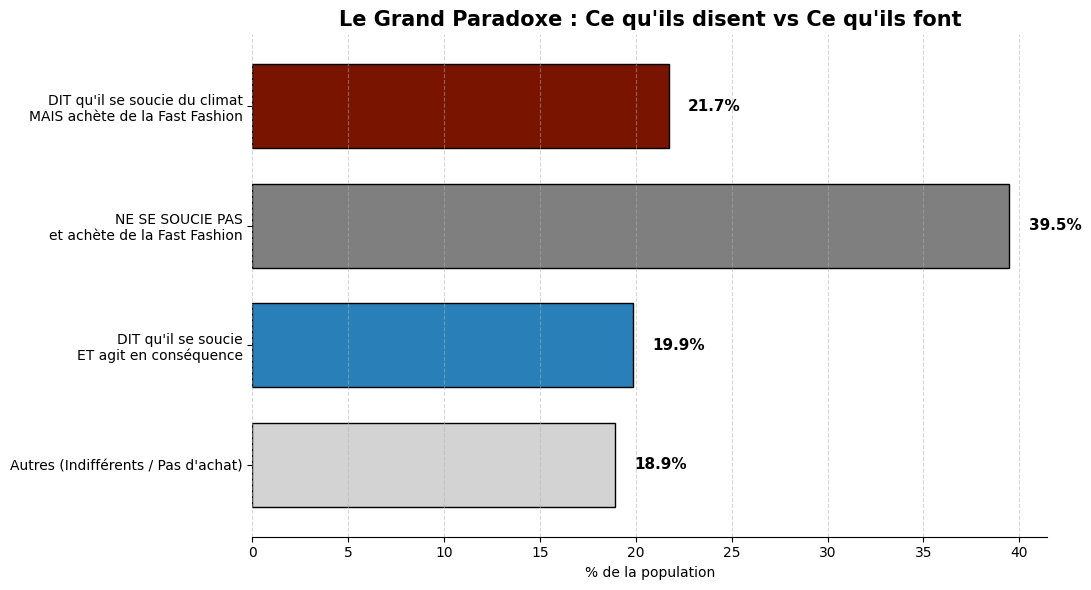

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# ==============================================================================
# 2. O DIAGNÓSTICO: DISCURSO VS REALIDADE (SEM RÓTULOS)
# ==============================================================================
print("--- 2. DIAGNOSTIC : LE GAP ENTRE PAROLE ET ACTE ---")

# 1. CRIAR AS CATEGORIAS DESCRITIVAS
# Em vez de nomes, usamos frases que descrevem a contradição
df_clean['Comportement'] = 'Neutre'

mask_conscious = df_clean['Souci_Ethique'] >= 7
mask_fastfashion = df_clean['Utilise_FastFashion'].astype(str).str.contains('Oui', case=False, na=False)

# Categoria 1: O Alvo da Crítica (Diz que importa, mas compra)
df_clean.loc[mask_conscious & mask_fastfashion, 'Comportement'] = "DIT qu'il se soucie du climat\nMAIS achète de la Fast Fashion"

# Categoria 2: O Coerente (Diz que importa e não compra)
df_clean.loc[mask_conscious & ~mask_fastfashion, 'Comportement'] = "DIT qu'il se soucie\nET agit en conséquence"

# Categoria 3: O Sincero (Não liga e compra)
df_clean.loc[~mask_conscious & mask_fastfashion, 'Comportement'] = "NE SE SOUCIE PAS\net achète de la Fast Fashion"

# Categoria 4: O Resto (Indiferentes que não compram - raro ou sem dados)
df_clean.loc[~mask_conscious & ~mask_fastfashion, 'Comportement'] = "Autres (Indifférents / Pas d'achat)"

# 2. CALCULAR
counts = df_clean['Comportement'].value_counts(normalize=True) * 100

# Ordem para contar a história (Do Problema para a Solução)
order_desc = [
    "DIT qu'il se soucie du climat\nMAIS achète de la Fast Fashion", # O GAP (Vinho)
    "NE SE SOUCIE PAS\net achète de la Fast Fashion",                # O Sincero (Cinza Escuro)
    "DIT qu'il se soucie\nET agit en conséquence",                   # O Ideal (Verde/Azul)
    "Autres (Indifférents / Pas d'achat)"                            # O Resto (Cinza Claro)
]

# Reindexar e limpar
counts = counts.reindex(order_desc).fillna(0)
# Removemos o grupo "Outros" se for muito pequeno para não poluir
if counts["Autres (Indifférents / Pas d'achat)"] < 2:
    counts = counts.drop("Autres (Indifférents / Pas d'achat)")
    cols_map = [0, 1, 2] # Ajuste de índice
else:
    cols_map = [0, 1, 2, 3]

# 3. CORES (Vinho para o Gap, Cinzas para o resto, Azul/Verde para o coerente)
colors_list = []
for label in counts.index:
    if "MAIS achète" in label: # O Hipócrita
        colors_list.append('#791401') # VINHO (Foco total aqui)
    elif "ET agit" in label:   # O Coerente
        colors_list.append('#2980B9') # AZUL CERULEO (Ou Verde se preferir)
    elif "NE SE SOUCIE PAS" in label:
        colors_list.append('#7f7f7f') # CINZA ESCURO
    else:
        colors_list.append('#D3D3D3') # CINZA CLARO

# 4. VISUALIZAÇÃO
plt.figure(figsize=(11, 6))

# Gráfico de Barras Horizontais
ax = counts.plot(kind='barh', color=colors_list, edgecolor='black', width=0.7)

# Títulos
plt.title('Le Grand Paradoxe : Ce qu\'ils disent vs Ce qu\'ils font', fontsize=15, fontweight='bold')
plt.xlabel('% de la population')
plt.ylabel('') # Tira o label do eixo Y pq o texto já explica

# Adicionar valores
for p in ax.patches:
    if p.get_width() > 0:
        ax.annotate(f'{p.get_width():.1f}%',
                    (p.get_width() + 1, p.get_y() + p.get_height()/2),
                    va='center', fontweight='bold', fontsize=11)

# Inverter o eixo Y para o "Gap" (Vinho) ficar no topo
plt.gca().invert_yaxis()

# Grid apenas vertical
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Remover bordas desnecessárias (spines)
sns.despine(left=True, bottom=False)

plt.tight_layout()
plt.show()

--- 2. RÉSEAU D'ASSOCIATION (QU'EST-CE QUI VA AVEC QUOI ?) ---


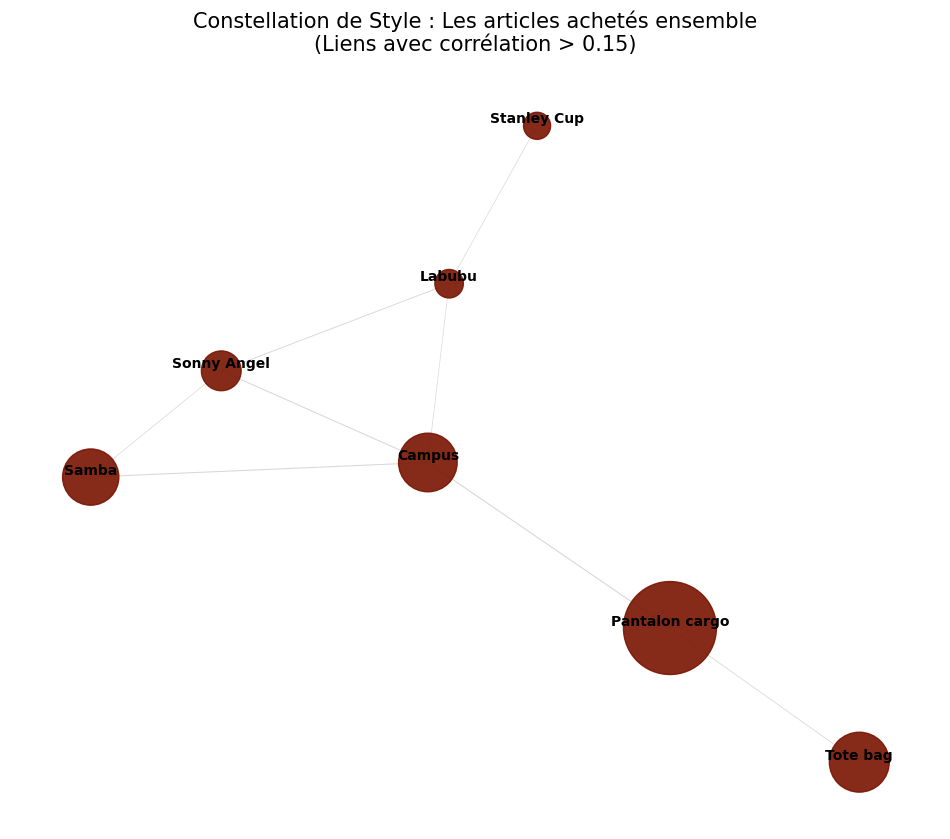

Como ler este gráfico:
- Bolinhas Grandes: Itens muito comprados.
- Linhas: Conexões fortes. Se dois itens estão ligados, eles compõem um 'Look'.
- Itens isolados: São peças órfãs que não combinam com o padrão geral.


In [ ]:
# ==============================================================================
# 2. A CONSTELAÇÃO DE ESTILO (Rede de Produtos)
# ==============================================================================
print("--- 2. RÉSEAU D'ASSOCIATION (QU'EST-CE QUI VA AVEC QUOI ?) ---")

# 1. Preparar os dados (Igual ao anterior)
itens_dummies = df_clean['Type_Articles_Achetes'].str.get_dummies(sep=';')

# Calculamos a Correlação
corr_matrix = itens_dummies.corr()

# 2. CONSTRUIR O GRAFO
# Vamos transformar a matriz em uma lista de conexões (Links)
links = corr_matrix.stack().reset_index()
links.columns = ['Item_A', 'Item_B', 'Correlação']

# FILTRO 1: Remover auto-correlação (Samba com Samba)
links = links[links['Item_A'] != links['Item_B']]

# FILTRO 2: Só mostrar conexões FORTES (O segredo para o gráfico não virar um rabisco)
# Ajuste este valor (0.15 ou 0.20) se o gráfico ficar muito cheio ou muito vazio
threshold = 0.15
strong_links = links[links['Correlação'] > threshold]

# Criar o objeto Grafo
G = nx.from_pandas_edgelist(strong_links, 'Item_A', 'Item_B', 'Correlação')

# 3. VISUALIZAÇÃO
plt.figure(figsize=(12, 10))

# Layout: Algoritmo que "empurra" os nós para ficarem bonitos (spring_layout)
pos = nx.spring_layout(G, k=0.5, seed=42) # k ajusta a distância entre nós

# Tamanho dos Nós baseado na popularidade do item
popularity = itens_dummies.sum()
node_sizes = [popularity.get(node, 10) * 20 for node in G.nodes()]

# Desenhar as Linhas (Conexões) - Cinza
nx.draw_networkx_edges(G, pos,
                       alpha=0.5,
                       edge_color='#B0B0B0',
                       width=[d['Correlação']*3 for (u, v, d) in G.edges(data=True)]) # Espessura = Força

# Desenhar os Nós (Bolinhas) - Vinho
nx.draw_networkx_nodes(G, pos,
                       node_size=node_sizes,
                       node_color='#791401',
                       alpha=0.9)

# Desenhar os Nomes
nx.draw_networkx_labels(G, pos,
                        font_size=10,
                        font_color='black',
                        font_weight='bold',
                        verticalalignment='bottom') # Texto um pouco acima da bolinha

plt.title(f"Constellation de Style : Les articles achetés ensemble\n(Liens avec corrélation > {threshold})", fontsize=15)
plt.axis('off') # Remove eixos X e Y
plt.show()

print("Como ler este gráfico:")
print("- Bolinhas Grandes: Itens muito comprados.")
print("- Linhas: Conexões fortes. Se dois itens estão ligados, eles compõem um 'Look'.")
print("- Itens isolados: São peças órfãs que não combinam com o padrão geral.")



---



# **CHAPITRE 4 : LE DILEMME DES CHOIX DURABLES** *"Le luxe de la responsabilité est-il réservé à une élite ?"*

--- 3. PROFIL DE CEUX QUI PAIENT PLUS (ARBRE DE DÉCISION) ---


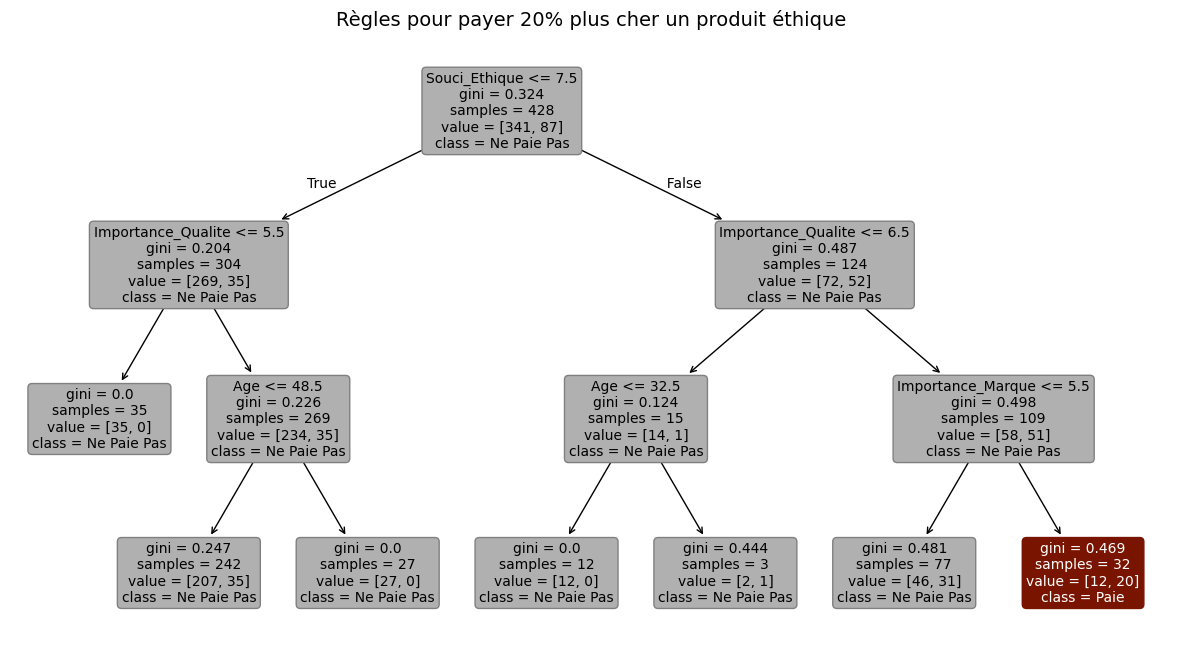

In [ ]:
# ==============================================================================
# 3. ARBRE DE DÉCISION (Qui paie plus cher pour l'éthique ?)
print("--- 3. PROFIL DE CEUX QUI PAIENT PLUS (ARBRE DE DÉCISION) ---")

if 'Pret_A_Payer_Plus' in df_clean.columns:
    # 1. Dados
    target = (df_clean['Pret_A_Payer_Plus'] >= 8).astype(int)

    cols_features = ['Age', 'Importance_Prix', 'Importance_Qualite', 'Importance_Marque', 'Souci_Ethique']
    existing_feats = [c for c in cols_features if c in df_clean.columns]
    features = df_clean[existing_feats].dropna()

    common_index = features.index.intersection(target.index)
    features = features.loc[common_index]
    target = target.loc[common_index]

    # 2. Entraînement ORIGINAL (Sem 'balanced')
    # Voltamos para o cálculo estatístico padrão: 1 pessoa = 1 voto.
    tree = DecisionTreeClassifier(max_depth=3,
                                  random_state=42)
    tree.fit(features, target)

    # 3. Gráfico
    plt.figure(figsize=(15, 8))

    annotations = plot_tree(tree,
                            feature_names=features.columns,
                            class_names=['Ne Paie Pas', 'Paie'],
                            filled=True,
                            rounded=True,
                            fontsize=10)

    # 4. Pintura Manual (Apenas Visual)
    wine_hex = "#791401"
    grey_hex = "#B0B0B0"

    for text in annotations:
        bbox = text.get_bbox_patch()
        if bbox is None: continue

        current_color = bbox.get_facecolor()
        current_alpha = current_color[3]
        label_text = text.get_text()

        if "class = Paie" in label_text:
            # Pinta a caixa de Vinho
            new_color = mcolors.to_rgba(wine_hex, alpha=current_alpha)
            bbox.set_facecolor(new_color)
            bbox.set_edgecolor(wine_hex)

            # --- AQUI ESTÁ O QUE VOCÊ PEDIU ---
            # Muda a fonte para BRANCO apenas na caixa Vinho
            text.set_color('white')
            # ----------------------------------

        else:
            # Pinta a caixa de Cinza
            new_color = mcolors.to_rgba(grey_hex, alpha=current_alpha)
            bbox.set_facecolor(new_color)
            bbox.set_edgecolor("grey")

            # Garante que a fonte no fundo cinza seja preta
            text.set_color('black')

    plt.title('Règles pour payer 20% plus cher un produit éthique', fontsize=14)
    plt.show()

else:
    print("Colonne cible introuvable.")

# **CHAPITRE 5 : SOUS EMPRISE** *"Anatomie du sacrifice et de la culpabilité"*

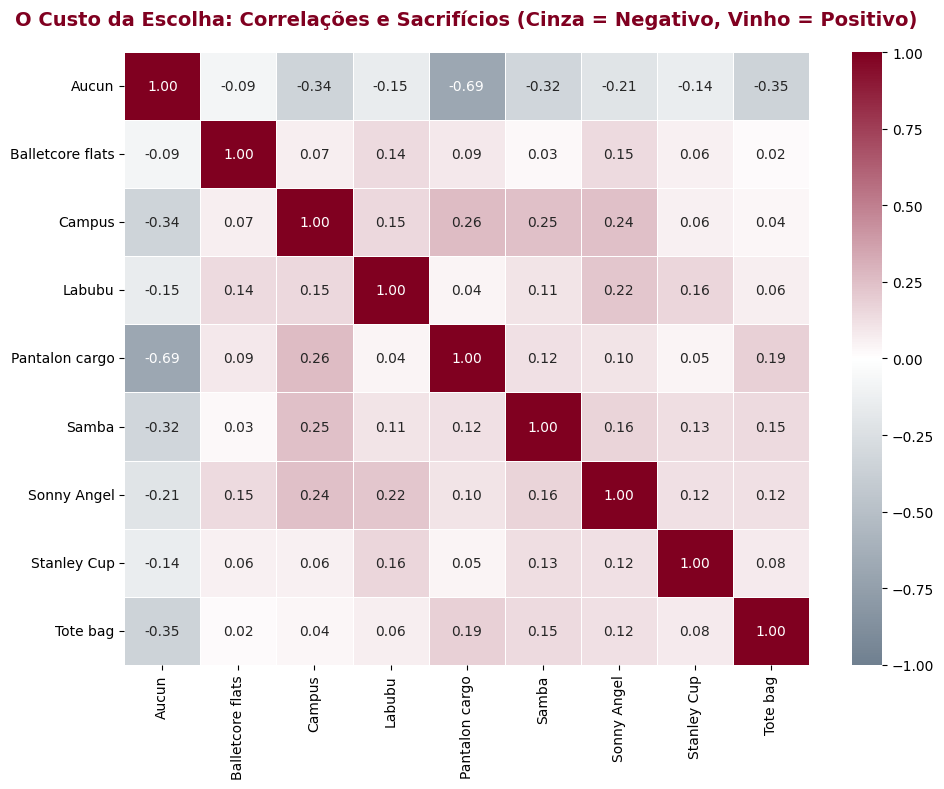

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. RECRIANDO O COLORMAP (CINZA E VINHO) ---
# Definindo as cores hexadecimais:
# Cinza (#708090) -> Branco (#FFFFFF) -> Vinho (#800020)
colors = ["#708090", "#FFFFFF", "#800020"]
custom_cmap = LinearSegmentedColormap.from_list("GreyToWine", colors)

# --- 2. RODANDO O GRÁFICO DE CORRELAÇÃO NOVAMENTE ---
plt.figure(figsize=(10, 8))

# O Heatmap usando o seu colormap personalizado
sns.heatmap(
    corr_matrix,
    annot=True,            # Mostra os números
    cmap=custom_cmap,      # Usa o degradê Cinza -> Vinho
    vmin=-1, vmax=1,       # Garante que a escala vá de -1 a 1
    center=0,              # O zero será branco
    fmt=".2f",             # 2 casas decimais
    linewidths=0.5,        # Linhas brancas para separar
    linecolor='white'
)

plt.title('O Custo da Escolha: Correlações e Sacrifícios (Cinza = Negativo, Vinho = Positivo)',
          fontsize=14, fontweight='bold', color='#800020', pad=20)

plt.tight_layout()
plt.show()


--- 5. INDICE DE VICTIME DE LA MODE ---
Palette appliquée : {'Oui': '#791401', 'Non, mais je connais ces plateformes': '#2980B9', 'Non, je ne connais pas ces plateformes': '#B0B0B0'}


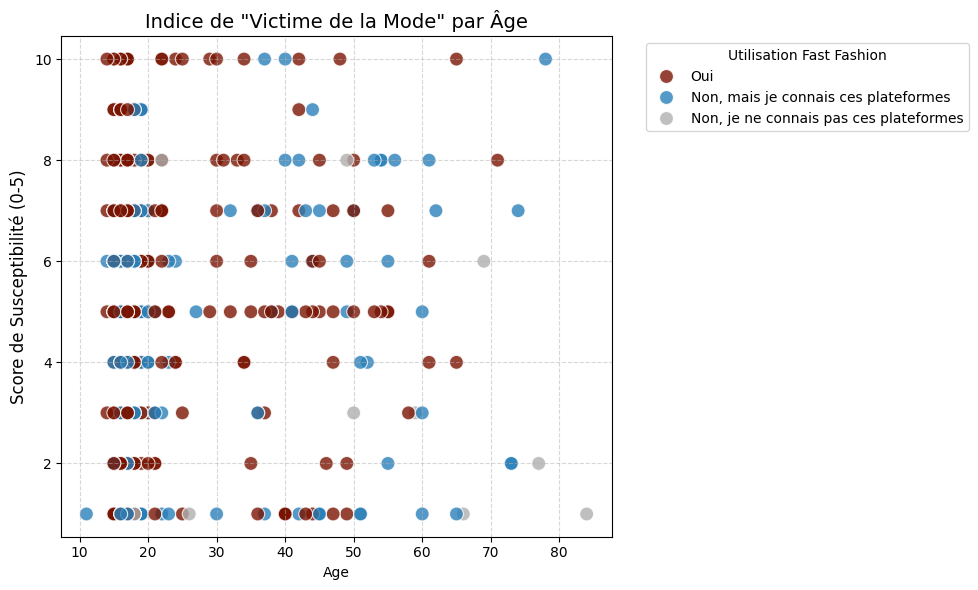

In [ ]:
# ==============================================================================
# 5. FASHION VICTIM INDEX (Indice de Victime de la Mode)
print("--- 5. INDICE DE VICTIME DE LA MODE ---")

# 1. Definição das Colunas e Cálculo do Score (Mesma lógica)
cols_victim = ['Influence_Sociale', 'Importance_Tendance', 'Culpabilite']
actual_cols = [c for c in cols_victim if c in df_clean.columns]
if not actual_cols:
    actual_cols = [c for c in df_clean.columns if c in ['Influence_Tendances', 'Influence_Reseaux', 'Sentiment_Culpabilite']]

for col in actual_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce').fillna(0)

if actual_cols:
    df_clean['Fashion_Victim_Score'] = df_clean[actual_cols].mean(axis=1)

    # --- 2. CONFIGURAÇÃO MANUAL DAS CORES ---
    # Aqui definimos as cores EXATAS para as frases que apareceram no seu gráfico
    wine_hex = '#791401'
    grey_hex = '#B0B0B0'
    blue_hex = '#2980B9'

    colors_dict = {
        'Oui': wine_hex,
        'Non, mais je connais ces plateformes': blue_hex,    # O "Meio Termo" vira Azul
        'Non, je ne connais pas ces plateformes': grey_hex   # O "Não Absoluto" vira Cinza
    }

    # Fallback: Caso apareça alguma resposta extra (ex: "Sans opinion"), pintamos de azul também
    unique_vals = df_clean['Utilise_FastFashion'].unique()
    for val in unique_vals:
        if val not in colors_dict:
            colors_dict[val] = blue_hex

    print(f"Palette appliquée : {colors_dict}")

    # 3. Visualização
    plt.figure(figsize=(10, 6))

    sns.scatterplot(
        data=df_clean,
        x='Age',
        y='Fashion_Victim_Score',
        hue='Utilise_FastFashion',
        palette=colors_dict,
        alpha=0.8,
        s=100
    )

    plt.title('Indice de "Victime de la Mode" par Âge', fontsize=14)
    plt.ylabel('Score de Susceptibilité (0-5)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)

    # Ajuste da legenda para não ficar em cima dos pontos
    plt.legend(title='Utilisation Fast Fashion', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

else:
    print("Colonnes nécessaires pour l'indice non trouvées.")

# **CHAPITRE 6 : LE PRISME DU CONSOMMATEUR** *"La fragmentation des comportements"*

--- MOYENNES RÉELLES CALCULÉES PAR L'ALGORITHME ---
           Age  Influence_Reseaux  Importance_Qualite  Importance_Prix
Cluster                                                               
0        48.06               2.71                8.58             8.39
1        22.05               2.26                8.32             8.17
2        18.91               6.31                7.80             7.90
3        26.42               3.03                5.85             6.95


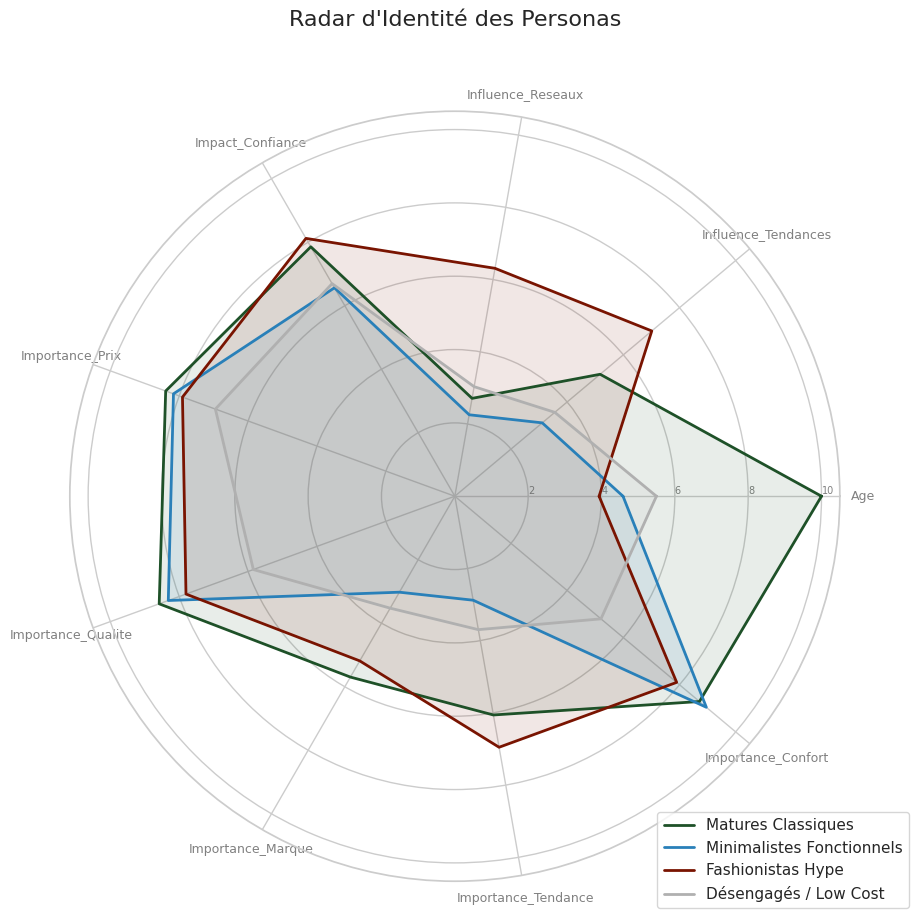

/tmp/ipython-input-1276348729.py:128: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




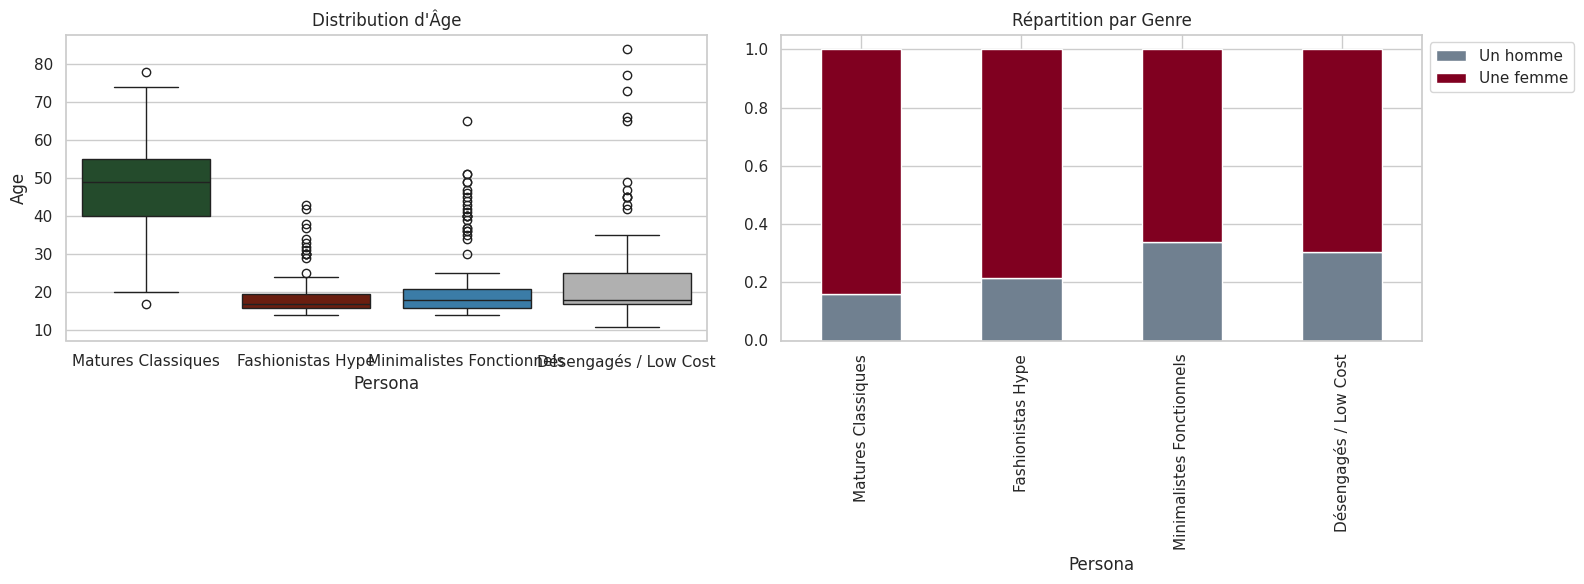

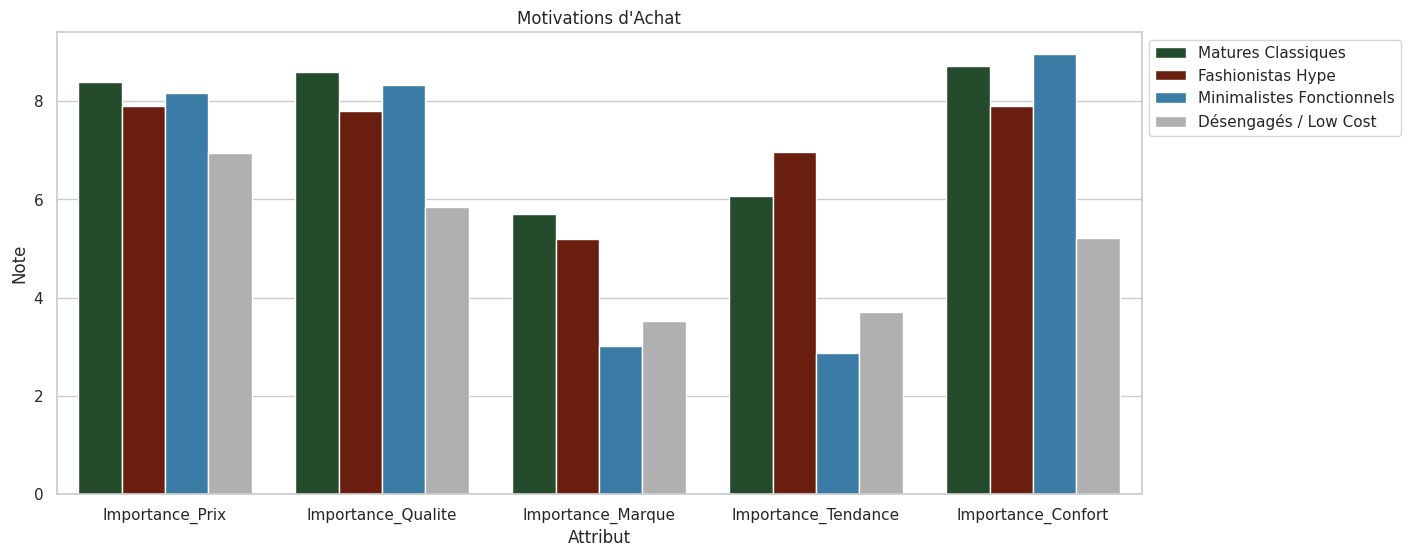

<Figure size 800x500 with 0 Axes>

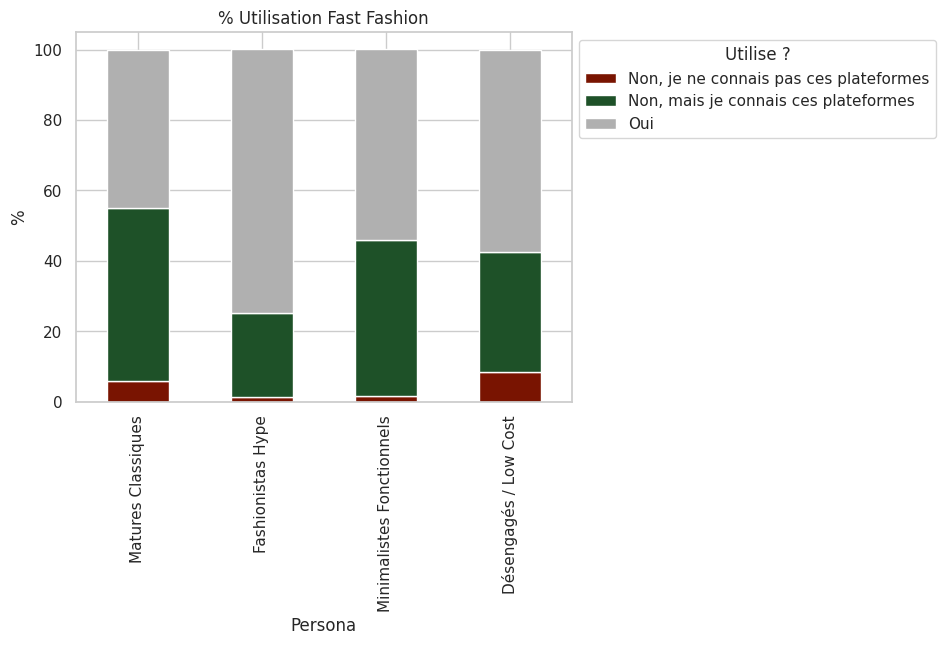

In [ ]:
# ==============================================================================
# SCRIPT FINAL : ANALYSE DES PERSONAS (CLUSTERING K-MEANS)
# ==============================================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from math import pi

# 1. PRÉPARATION (Utilise df_clean créé précédemment)
# ------------------------------------------------------------------------------
features_model = [
    'Age',
    'Influence_Tendances',
    'Influence_Reseaux',
    'Impact_Confiance',
    'Importance_Prix',
    'Importance_Qualite',
    'Importance_Marque',
    'Importance_Tendance',
    'Importance_Confort'
]

# On garde uniquement les lignes complètes pour le calcul
df_cluster = df_clean[features_model].dropna().copy()

# Ajout des colonnes utiles pour les graphiques (mais pas pour le calcul mathématique)
cols_context = ['Genre', 'Pression_Sociale', 'Souci_Ethique', 'Utilise_FastFashion']
for col in cols_context:
    if col in df_clean.columns:
        df_cluster[col] = df_clean.loc[df_cluster.index, col]

# Petite correction pour la Pression Sociale (Texte -> Nombre)
map_echelle = {'Jamais': 1, 'Rarement': 2, 'Parfois': 3, 'Souvent': 4, 'Toujours': 5}
if 'Pression_Sociale' in df_cluster.columns and df_cluster['Pression_Sociale'].dtype == 'O':
    df_cluster['Pression_Sociale'] = df_cluster['Pression_Sociale'].map(map_echelle)

# 2. LE CALCUL MATHÉMATIQUE (K-MEANS) - On ne touche pas à ça !
# ------------------------------------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[features_model])

# L'algorithme trouve seul les 4 groupes naturels
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_cluster['Cluster'] = kmeans.fit_predict(X_scaled)

# 3. L'INTERPRÉTATION (Donner des noms aux groupes trouvés)
# ------------------------------------------------------------------------------
# On regarde les moyennes réelles calculées par l'algorithme
means = df_cluster.groupby('Cluster')[features_model].mean()

def nommer_persona(row):
    # Ici, on adapte les règles aux données réelles pour que les étiquettes collent bien

    # Groupe des plus âgés (Moyenne réelle ~48 ans)
    if row['Age'] > 35:
        return "Matures Classiques"

    # Groupe des très influencés (Moyenne réelle Influence > 5)
    if row['Influence_Reseaux'] > 4.5:
        return "Fashionistas Hype"

    # Groupe qui veut la Qualité mais pas la Tendance
    # (Moyenne réelle : Qualité > 8, Tendance < 3)
    if row['Importance_Qualite'] > 7.0 and row['Importance_Tendance'] < 4.0:
        return "Minimalistes Fonctionnels"

    # Le reste (Jeunes, budget serré, moins d'exigences spécifiques)
    return "Désengagés / Low Cost"

# On applique les noms
persona_map = means.apply(nommer_persona, axis=1).to_dict()
df_cluster['Persona'] = df_cluster['Cluster'].map(persona_map)

# Couleurs pour les graphiques
order_personas = ["Matures Classiques", "Fashionistas Hype", "Minimalistes Fonctionnels", "Désengagés / Low Cost"]
custom_palette = {
    'Matures Classiques': '#1E5128',
    'Fashionistas Hype': '#791401',
    'Minimalistes Fonctionnels': '#2980B9',
    'Désengagés / Low Cost': '#B0B0B0'
}
sns.set_theme(style="whitegrid")

# Affichage des moyennes pour preuve
print("--- MOYENNES RÉELLES CALCULÉES PAR L'ALGORITHME ---")
print(means[['Age', 'Influence_Reseaux', 'Importance_Qualite', 'Importance_Prix']].round(2))

# 4. VISUALISATION : RADAR CHART
# ------------------------------------------------------------------------------
def plot_radar(df_means, features_list):
    plot_data = df_means.copy()
    plot_data['Age'] = (plot_data['Age'] / plot_data['Age'].max()) * 10 # Normalisation pour l'affichage

    categories = features_list
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories, color='grey', size=9)
    ax.set_rlabel_position(0)
    plt.yticks([2,4,6,8,10], ["2","4","6","8","10"], color="grey", size=7)
    plt.ylim(0, 10.5)

    for i, row in plot_data.iterrows():
        persona_name = persona_map[i]
        color = custom_palette.get(persona_name, 'black')
        values = row[features_list].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=persona_name, color=color)
        ax.fill(angles, values, color, alpha=0.1)

    plt.title('Radar d\'Identité des Personas', size=16, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 0.1))
    plt.show()

plot_radar(means, features_model)

# 5. VISUALISATION : DÉTAILS
# ------------------------------------------------------------------------------
# Age et Genre
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot(x='Persona', y='Age', data=df_cluster, order=order_personas, palette=custom_palette, ax=ax[0])
ax[0].set_title('Distribution d\'Âge')

if 'Genre' in df_cluster.columns:
    ct = pd.crosstab(df_cluster['Persona'], df_cluster['Genre'], normalize='index')
    ct = ct.reindex(order_personas).fillna(0)
    ct.plot(kind='bar', stacked=True, ax=ax[1], colormap=custom_cmap)
    ax[1].set_title('Répartition par Genre')
    ax[1].legend(bbox_to_anchor=(1, 1))
plt.tight_layout(); plt.show()

# Motivations
cols_imp = ['Importance_Prix', 'Importance_Qualite', 'Importance_Marque', 'Importance_Tendance', 'Importance_Confort']
df_melt = df_cluster.melt(id_vars='Persona', value_vars=cols_imp, var_name='Attribut', value_name='Note')
plt.figure(figsize=(14, 6))
sns.barplot(x='Attribut', y='Note', hue='Persona', data=df_melt, hue_order=order_personas, palette=custom_palette, errorbar=None)
plt.title('Motivations d\'Achat')
plt.legend(bbox_to_anchor=(1, 1)); plt.show()

# Fast Fashion
if 'Utilise_FastFashion' in df_cluster.columns:
    plt.figure(figsize=(8, 5))
    ct_ff = pd.crosstab(df_cluster['Persona'], df_cluster['Utilise_FastFashion'], normalize='index') * 100
    ct_ff = ct_ff.reindex(order_personas).fillna(0)
    ct_ff.plot(kind='bar', stacked=True, color=['#791401', '#1E5128', '#B0B0B0'])
    plt.title('% Utilisation Fast Fashion')
    plt.ylabel('%')
    plt.legend(title='Utilise ?', bbox_to_anchor=(1, 1)); plt.show()

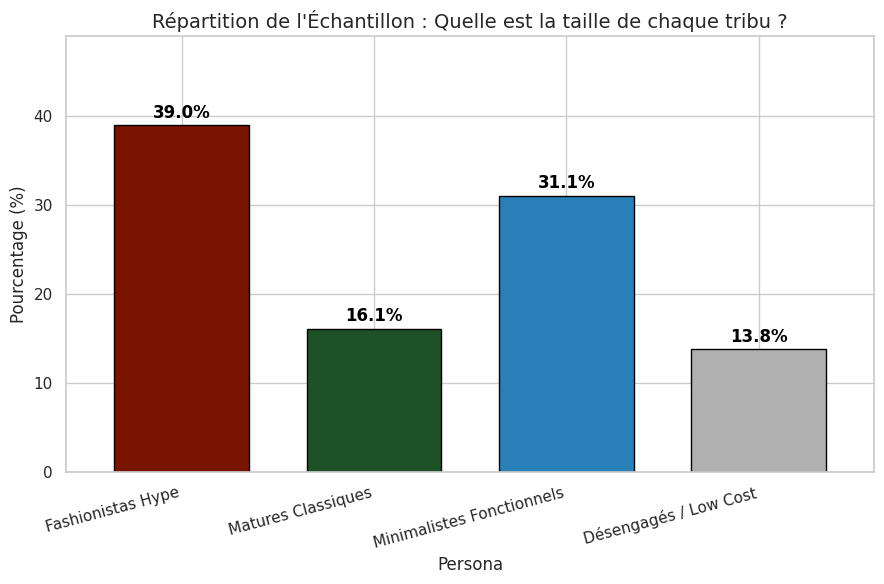

--- COMPOSITION DES GROUPES ---
Persona
Fashionistas Hype            39.0
Matures Classiques           16.1
Minimalistes Fonctionnels    31.1
Désengagés / Low Cost        13.8
Name: proportion, dtype: float64


In [ ]:
# ------------------------------------------------------------------------------
# 5. TAILLE DES GROUPES (PART D'AUDIENCE)
# ------------------------------------------------------------------------------
# 1. DÉFINITION DE LA PALETTE (Les 4 Couleurs)
custom_palette = {
    'Matures Classiques': '#1E5128',
    'Fashionistas Hype': '#791401',
    'Minimalistes Fonctionnels': '#2980B9',
    'Désengagés / Low Cost': '#B0B0B0'
}

# 2. DÉFINITION DE L'ORDRE
# On force cet ordre pour que le graphique soit toujours organisé de la même façon
order_personas = [
    'Fashionistas Hype',
    'Matures Classiques',
    'Minimalistes Fonctionnels',
    'Désengagés / Low Cost'
]

# 3. PRÉPARATION DES DONNÉES
# Calcul des pourcentages
perc = df_cluster['Persona'].value_counts(normalize=True) * 100

# On réindexe pour suivre l'ordre des couleurs et éviter les erreurs
# Si une persona manque dans les données, elle apparaîtra comme NaN (on remplit avec 0)
perc = perc.reindex(order_personas).fillna(0)

plt.figure(figsize=(9, 6))

# 4. CRÉATION DU GRAPHIQUE
# On map les couleurs directement en lisant l'index du dataframe
couleurs_barres = [custom_palette.get(x, 'grey') for x in perc.index]

ax = perc.plot(kind='bar', color=couleurs_barres, edgecolor='black', width=0.7)

plt.title('Répartition de l\'Échantillon : Quelle est la taille de chaque tribu ?', fontsize=14)
plt.ylabel('Pourcentage (%)')
plt.xticks(rotation=15, ha='right') # Rotation légère pour lire les noms
plt.ylim(0, perc.max() + 10) # Espace pour les chiffres

# Ajouter les chiffres au-dessus des barres
for p in ax.patches:
    # On n'affiche le texte que si la barre existe (>0)
    if p.get_height() > 0:
        ax.annotate(f'{p.get_height():.1f}%',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 9),
                    textcoords = 'offset points',
                    fontweight='bold',
                    color='black')

plt.tight_layout()
plt.show()

# Afficher les valeurs dans la console également
print("--- COMPOSITION DES GROUPES ---")
print(perc.round(1))



---



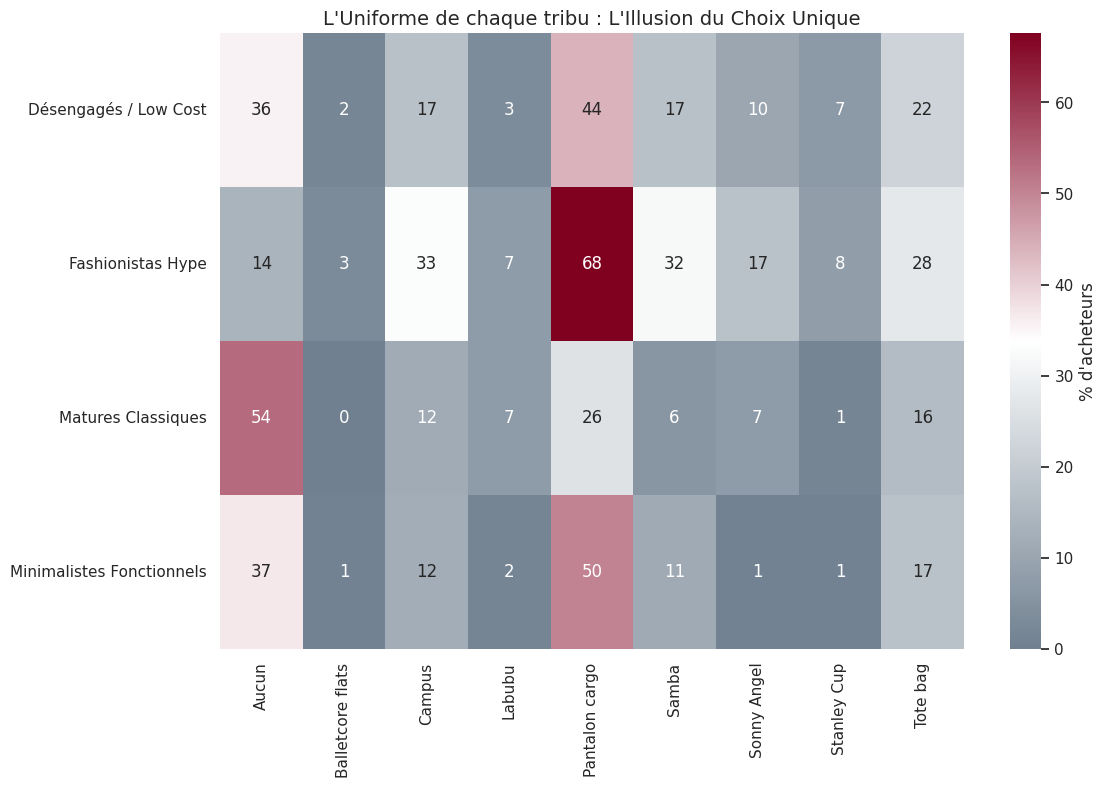

Interprétation 1 : Observez les colonnes rouges foncées.
Elles montrent les articles 'obligatoires' pour appartenir à une tribu (ex: Samba pour les Fashionistas ?).


In [ ]:
# Nous devons récupérer certaines colonnes de texte originales dans df_clean
# qui n'étaient pas dans le modèle mathématique, mais qui sont utiles ici.

cols_critiques = ['Type_Articles_Achetes', 'Peur_Etre_Demode', 'Sentiment_Culpabilite']

# On s'assure que ces colonnes sont bien dans notre dataframe d'analyse
for col in cols_critiques:
    if col in df_clean.columns:
        # On copie les données en utilisant l'index pour être sûr que ça correspond aux bons clients
        df_cluster[col] = df_clean.loc[df_cluster.index, col]

# Conversion des échelles de texte en nombres (si ce n'est pas déjà fait)
map_frequence = {'Jamais': 1, 'Rarement': 2, 'Parfois': 3, 'Souvent': 4, 'Toujours': 5}
cols_a_convertir = ['Peur_Etre_Demode', 'Sentiment_Culpabilite']

for col in cols_a_convertir:
    if df_cluster[col].dtype == 'O': # Si c'est du texte (Objet)
        df_cluster[col] = df_cluster[col].map(map_frequence)

# Configuration du style
sns.set_theme(style="whitegrid")
# On réutilise la palette définie précédemment
palette_ref = custom_palette if 'custom_palette' in locals() else None
ordre_ref = order_personas if 'order_personas' in locals() else None

# ------------------------------------------------------------------------------
# ANALYSE 1 : L'EFFET "BLEU CÉRULÉEN" (L'Uniformisation)
# ------------------------------------------------------------------------------
# Quels articles spécifiques chaque tribu achète-t-elle ?
if 'Type_Articles_Achetes' in df_cluster.columns:
    # Séparation des articles (ex: "Samba;Cargo" -> colonnes séparées)
    items_dummies = df_cluster['Type_Articles_Achetes'].str.get_dummies(sep=';')

    # On lie les articles à la Persona
    df_items = pd.concat([df_cluster['Persona'], items_dummies], axis=1)

    # Calcul du % d'achat par Persona
    heatmap_data = df_items.groupby('Persona').mean() * 100

    # Visualisation
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap=custom_cmap, cbar_kws={'label': '% d\'acheteurs'})
    plt.title('L\'Uniforme de chaque tribu : L\'Illusion du Choix Unique', fontsize=14)
    plt.ylabel('')
    plt.show()

    print("Interprétation 1 : Observez les colonnes rouges foncées.")
    print("Elles montrent les articles 'obligatoires' pour appartenir à une tribu (ex: Samba pour les Fashionistas ?).")



In [ ]:
# ------------------------------------------------------------------------------
# 0. CONFIGURATION DES COULEURS (VOS COULEURS)
# ------------------------------------------------------------------------------
custom_palette = {
    'Matures Classiques': '#1E5128',
    'Fashionistas Hype': '#791401',
    'Minimalistes Fonctionnels': '#2980B9',
    'Désengagés / Low Cost': '#B0B0B0'
}

# Ordre d'affichage
order_personas = [
    'Fashionistas Hype',
    'Matures Classiques',
    'Minimalistes Fonctionnels',
    'Désengagés / Low Cost'
]

--- 2. OBSOLESCENCE PSYCHOLOGIQUE ---


/tmp/ipython-input-2200324900.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




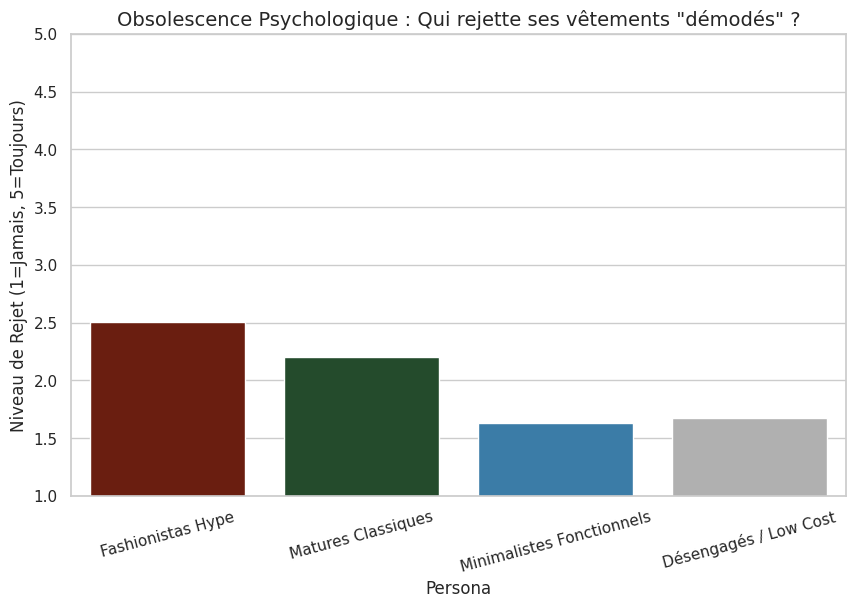

In [ ]:
# ------------------------------------------------------------------------------
# ANALYSE 2 : OBSOLESCENCE PSYCHOLOGIQUE
# ------------------------------------------------------------------------------
print("--- 2. OBSOLESCENCE PSYCHOLOGIQUE ---")

if 'Peur_Etre_Demode' in df_cluster.columns:
    plt.figure(figsize=(10, 6))

    # AQUI APLICAMOS AS SUAS 4 CORES
    sns.barplot(x='Persona', y='Peur_Etre_Demode', data=df_cluster,
                palette=custom_palette, # <--- Cores aqui
                order=order_personas,
                errorbar=None)

    plt.title('Obsolescence Psychologique : Qui rejette ses vêtements "démodés" ?', fontsize=14)
    plt.ylabel('Niveau de Rejet (1=Jamais, 5=Toujours)')
    plt.ylim(1, 5)
    plt.xticks(rotation=15)
    plt.show()



--- 3. LE COÛT ÉMOTIONNEL ---


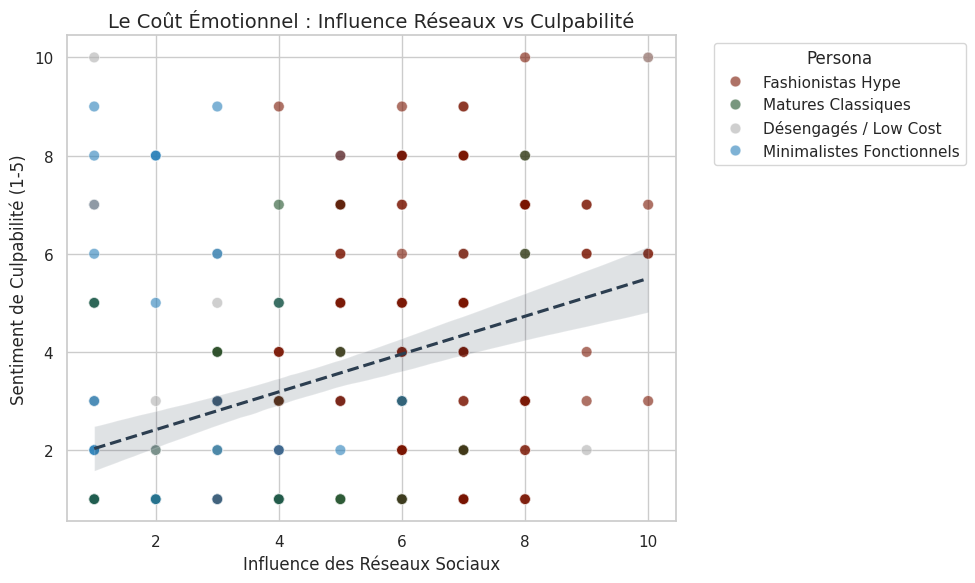

In [ ]:
# ------------------------------------------------------------------------------
# ANALYSE 3 : LA MATRICE DE LA CULPABILITÉ
# ------------------------------------------------------------------------------
print("--- 3. LE COÛT ÉMOTIONNEL ---")

if 'Influence_Reseaux' in df_cluster.columns and 'Sentiment_Culpabilite' in df_cluster.columns:
    plt.figure(figsize=(10, 6))

    # Scatterplot COLORIDO por Persona (Para ver quem sofre mais)
    sns.scatterplot(
        data=df_cluster,
        x='Influence_Reseaux',
        y='Sentiment_Culpabilite',
        hue='Persona',             # <--- Colore as bolinhas por grupo
        palette=custom_palette,    # <--- Usa suas cores (Vinho, Mostarda, etc)
        alpha=0.6,
        s=60
    )

    # Adiciona a linha de tendência (Regressão) em Preto/Cinza escuro para contraste
    sns.regplot(
        data=df_cluster,
        x='Influence_Reseaux',
        y='Sentiment_Culpabilite',
        scatter=False,             # Não desenha os pontos de novo (já desenhamos acima)
        color='#2C3E50',           # Linha escura elegante
        line_kws={'linestyle': '--'}
    )

    plt.title('Le Coût Émotionnel : Influence Réseaux vs Culpabilité', fontsize=14)
    plt.xlabel('Influence des Réseaux Sociaux')
    plt.ylabel('Sentiment de Culpabilité (1-5)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Persona')
    plt.tight_layout()
    plt.show()



---



# **CHAPITRE 7 : L'EFFET PAPILLON** *"L'impact invisible de l'industrie sur nos placards"*

/tmp/ipython-input-3195343739.py:49: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-3195343739.py:68: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




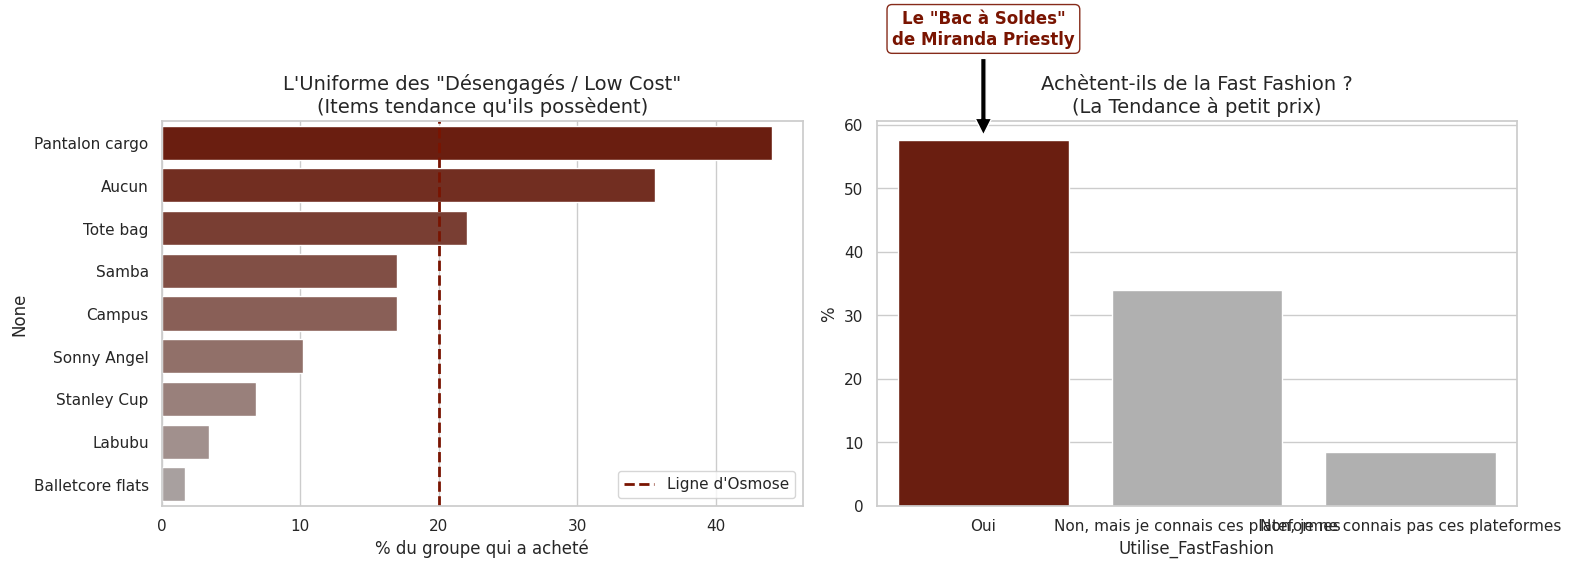

--- RÉSULTATS POUR LE GROUPE : DÉSENGAGÉS / LOW COST ---
Nombre de personnes analysées : 59

Top 3 des articles possédés par ceux qui 'ne suivent pas la mode' :
Pantalon cargo    44.1
Aucun             35.6
Tote bag          22.0
dtype: float64


In [ ]:
# 1. ISOLER LES SCEPTIQUES
# ------------------------------------------------------------------------------
# On filtre le dataframe pour ne garder que la persona "Désengagés"
nom_sceptique = "Désengagés / Low Cost"

# Vérification de sécurité
if nom_sceptique not in df_cluster['Persona'].unique():
    print(f"Attention : Le groupe '{nom_sceptique}' n'a pas été trouvé. Utilisation du premier groupe disponible.")
    nom_sceptique = df_cluster['Persona'].unique()[0]

df_sceptiques = df_cluster[df_cluster['Persona'] == nom_sceptique].copy()

# ==============================================================================
# 2. ANALYSE : QU'EST-CE QU'ILS POSSÈDENT VRAIMENT ?
# ==============================================================================

# Comptage des articles
if 'Type_Articles_Achetes' in df_sceptiques.columns:
    items_dummies = df_sceptiques['Type_Articles_Achetes'].str.get_dummies(sep=';')
    somme_items = items_dummies.sum().sort_values(ascending=False)
    # Calcul du pourcentage de possession
    pourcentage_items = (somme_items / len(df_sceptiques)) * 100
else:
    pourcentage_items = pd.Series()

# Utilisation de la Fast Fashion
if 'Utilise_FastFashion' in df_sceptiques.columns:
    ff_usage = df_sceptiques['Utilise_FastFashion'].value_counts(normalize=True) * 100
else:
    ff_usage = pd.Series()

# ==============================================================================
# 3. VISUALISATION (COULEURS : VINHO & CINZA)
# ==============================================================================
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Définition des couleurs exactes
wine_hex = '#791401'
grey_hex = '#B0B0B0'

# --- GRAPHIQUE 1 : L'UNIFORME (DEGRADÊ VINHO -> CINZA) ---
if not pourcentage_items.empty:
    # Création d'un dégradé personnalisé : Du Vin (Top items) vers le Gris (Items rares)
    # Cela donne un effet de classement visuel très propre
    cmap = mcolors.LinearSegmentedColormap.from_list("", [wine_hex, grey_hex])
    N = len(pourcentage_items)
    palette_gradient = [mcolors.to_hex(cmap(i/N)) for i in range(N)]

    sns.barplot(x=pourcentage_items.values, y=pourcentage_items.index, palette=palette_gradient, ax=ax[0])

    ax[0].set_title(f'L\'Uniforme des "{nom_sceptique}"\n(Items tendance qu\'ils possèdent)', fontsize=14)
    ax[0].set_xlabel('% du groupe qui a acheté')

    # Ligne d'Osmose (Seuil critique) - Rouge vif ou Vin foncé pour le contraste
    ax[0].axvline(x=20, color=wine_hex, linestyle='--', linewidth=2, label='Ligne d\'Osmose')
    ax[0].legend()

# --- GRAPHIQUE 2 : ORIGINE (FAST FASHION) ---
if not ff_usage.empty:
    # Logique de couleur : "Oui" = Vinho, Le reste = Gris
    couleurs_ff = []
    for label in ff_usage.index:
        if 'Oui' in str(label):
            couleurs_ff.append(wine_hex) # Le coupable en Vinho
        else:
            couleurs_ff.append(grey_hex) # Le reste en Gris

    sns.barplot(x=ff_usage.index, y=ff_usage.values, palette=couleurs_ff, ax=ax[1])

    ax[1].set_title('Achètent-ils de la Fast Fashion ?\n(La Tendance à petit prix)', fontsize=14)
    ax[1].set_ylabel('%')

    # Annotation "Miranda Priestly"
    try:
        # Trouve l'index de la réponse "Oui" pour placer la flèche
        idx_oui = [i for i, label in enumerate(ff_usage.index) if 'Oui' in str(label)][0]
        val_oui = ff_usage.iloc[idx_oui]

        ax[1].annotate('Le "Bac à Soldes"\nde Miranda Priestly',
                       xy=(idx_oui, val_oui), xytext=(idx_oui, val_oui + 15),
                       ha='center',
                       arrowprops=dict(facecolor='black', shrink=0.05),
                       bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=wine_hex, alpha=0.9),
                       color=wine_hex, fontweight='bold')
    except IndexError:
        pass

plt.tight_layout()
plt.show()

# Impression des résultats
print(f"--- RÉSULTATS POUR LE GROUPE : {nom_sceptique.upper()} ---")
print(f"Nombre de personnes analysées : {len(df_sceptiques)}")
print("\nTop 3 des articles possédés par ceux qui 'ne suivent pas la mode' :")
print(pourcentage_items.head(3).round(1))

--- 6.2 L'EFFET INFLUENCEUR : DIAGNOSTIC & CORRECTION ---
Exemples de valeurs trouvées (Influence) : [10  1  8  2  4]
Exemples de valeurs trouvées (Peur) : ['Parfois' 'Jamais' 'Rarement' 'Souvent']
Dados válidos recuperados: 428 linhas.


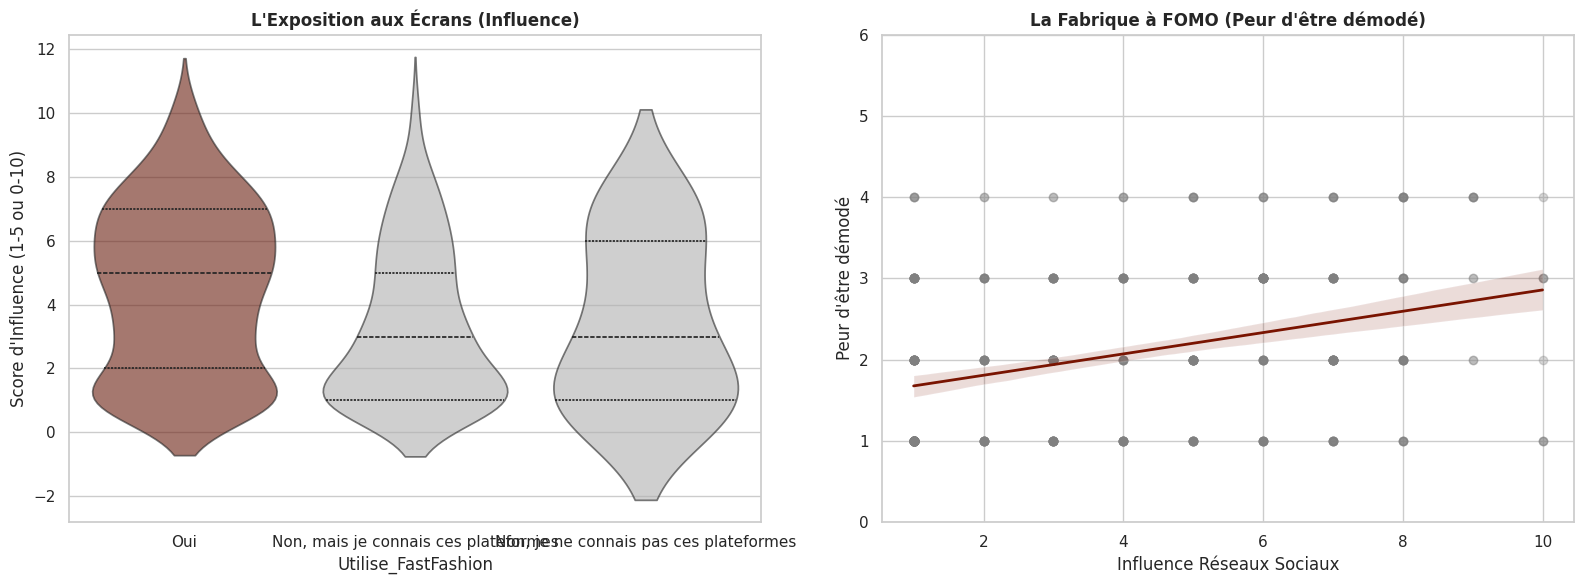

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ==============================================================================
# 6.2 DIAGNÓSTICO E CORREÇÃO ROBUSTA (FORÇA BRUTA)
# ==============================================================================
print("--- 6.2 L'EFFET INFLUENCEUR : DIAGNOSTIC & CORRECTION ---")

# 1. ESPIÃO DE DADOS: Vamos ver o que tem escrito nas colunas antes de mexer
print("Exemples de valeurs trouvées (Influence) :", df_clean['Influence_Reseaux'].unique()[:5])
if 'Peur_Etre_Demode' in df_clean.columns:
    print("Exemples de valeurs trouvées (Peur) :", df_clean['Peur_Etre_Demode'].unique()[:5])

# 2. FUNÇÃO DE LIMPEZA INTELIGENTE
# Essa função não liga para maiúsculas/minúsculas ou espaços extras
def converter_texto_para_numero(valor):
    if pd.isna(valor): return np.nan

    texto = str(valor).lower().strip() # Transforma em texto minúsculo e tira espaços

    # Tenta converter direto se for número (ex: "5" ou 5)
    try:
        return float(texto)
    except ValueError:
        pass

    # Procura palavras-chave
    if 'jamais' in texto or 'non' in texto or 'pas' in texto or 'aucun' in texto: return 1
    if 'rarement' in texto or 'peu' in texto: return 2
    if 'parfois' in texto or 'neutre' in texto or 'moyen' in texto: return 3
    if 'souvent' in texto or 'beaucoup' in texto: return 4
    if 'toujours' in texto or 'oui' in texto or 'enormément' in texto or 'très' in texto: return 5

    return np.nan # Se não entender nada, devolve vazio

# 3. APLICAR A LIMPEZA
cols_to_clean = ['Influence_Reseaux', 'Peur_Etre_Demode']
for col in cols_to_clean:
    if col in df_clean.columns:
        # Cria uma cópia para não estragar o original se der erro
        df_clean[f'{col}_Num'] = df_clean[col].apply(converter_texto_para_numero)

# 4. PREPARAR O PLOT (Usando as novas colunas numéricas)
# Agora usamos as colunas terminadas em "_Num"
cols_plot = ['Influence_Reseaux_Num', 'Peur_Etre_Demode_Num', 'Utilise_FastFashion']
df_plot = df_clean.dropna(subset=cols_plot).copy()

print(f"Dados válidos recuperados: {len(df_plot)} linhas.")

# ==============================================================================
# VISUALIZAÇÃO
# ==============================================================================
if len(df_plot) > 5: # Só desenha se tiver pelo menos 5 pessoas

    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # --- GRÁFICO 1: VIOLINO ---
    my_pal = {"Oui": "#791401", "Non": "#B0B0B0"}
    # Ajuste de cores para respostas extras
    for ans in df_plot['Utilise_FastFashion'].unique():
        if ans not in my_pal:
            if 'Oui' in str(ans): my_pal[ans] = "#791401"
            else: my_pal[ans] = "#B0B0B0"

    sns.violinplot(data=df_plot,
                   x='Utilise_FastFashion',
                   y='Influence_Reseaux_Num', # Usa a coluna numérica
                   hue='Utilise_FastFashion',
                   palette=my_pal,
                   ax=ax[0],
                   inner="quart",
                   alpha=0.6)

    ax[0].set_title("L'Exposition aux Écrans (Influence)", fontsize=12, fontweight='bold')
    ax[0].set_ylabel("Score d'Influence (1-5 ou 0-10)")

    # --- GRÁFICO 2: REGRESSÃO ---
    sns.regplot(data=df_plot,
                x='Influence_Reseaux_Num', # Usa a coluna numérica
                y='Peur_Etre_Demode_Num',  # Usa a coluna numérica
                ax=ax[1],
                scatter_kws={'alpha':0.3, 'color':'grey'},
                line_kws={'color':'#791401', 'linewidth': 2})

    ax[1].set_title("La Fabrique à FOMO (Peur d'être démodé)", fontsize=12, fontweight='bold')
    ax[1].set_xlabel("Influence Réseaux Sociaux")
    ax[1].set_ylabel("Peur d'être démodé")
    ax[1].set_ylim(0, 6)

    plt.tight_layout()
    plt.show()

else:
    print("ERRO CRÍTICO: Mesmo após a limpeza, não sobraram dados.")
    print("Verifique se as colunas estão vazias no Excel.")

In [ ]:
df_clean.columns

Index(['N°Obs', 'Frequence_Achat', 'Canal_Achat', 'Duree_Vie_GardeRobe',
       'Destination_Fin_Vie', 'Vetements_Jamais_Portes', 'Influence_Tendances',
       'Achat_Impulsif_Tendance', 'Pression_Sociale', 'Peur_Etre_Demode',
       'Impact_Confiance', 'Impact_Vie_Sociale', 'Influence_Reseaux',
       'Partage_Achats_Reseaux', 'Sentiment_Culpabilite',
       'Peur_Jugement_Social', 'Type_Articles_Achetes',
       'Connaissance_FastFashion', 'Utilise_FastFashion', 'Souci_Ethique',
       'Pret_A_Payer_Plus', 'Motivations_FastFashion', 'Age', 'Genre',
       'Vision_Mode_Conformisme', 'Situation_Pro',
       '(Quelle est votre situation professionnelle ?) Précisez :',
       'Importance_Prix', 'Importance_Qualite', 'Importance_Marque',
       'Importance_Tendance', 'Importance_Confort',
       'Bonjour,_Ce questionnaire porte sur la mode et son influence dans la vie _quotidienne._Il est anonyme et confidentiel, il ne vous _prendra que quelques minutes._Merci d'avance pour votre particip



---



# **Teste de novas visualizações**

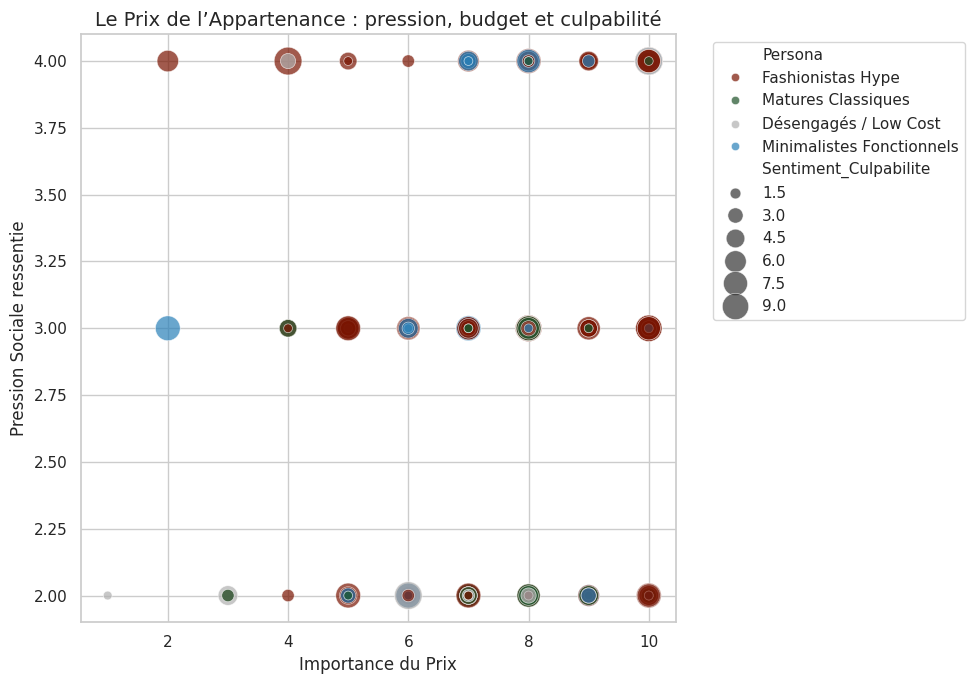

In [ ]:
# ==============================================================================
# VISUALISATION 2 : LE PRIX DE L'APPARTENANCE
# ==============================================================================

plt.figure(figsize=(10, 7))

sns.scatterplot(
    data=df_cluster,
    x='Importance_Prix',
    y='Pression_Sociale',
    size='Sentiment_Culpabilite',
    hue='Persona',
    palette=custom_palette,
    sizes=(40, 400),
    alpha=0.7
)

plt.title("Le Prix de l’Appartenance : pression, budget et culpabilité", fontsize=14)
plt.xlabel("Importance du Prix")
plt.ylabel("Pression Sociale ressentie")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

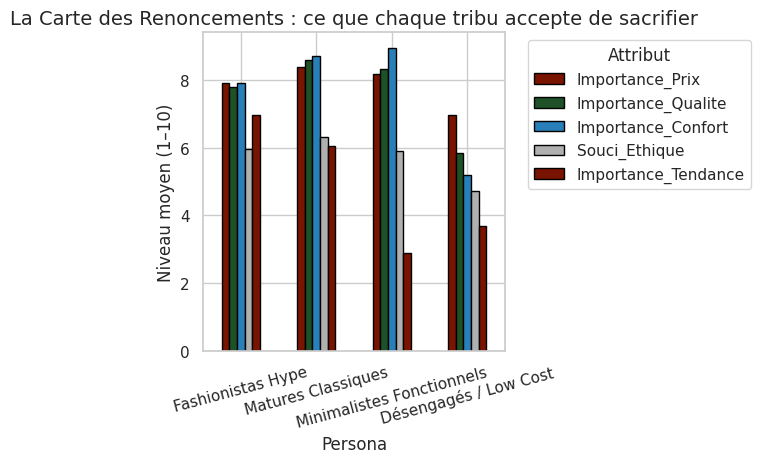

In [ ]:
# ==============================================================================
# VISUALISATION 3 : LA CARTE DES RENONCEMENTS
# ==============================================================================

cols_renoncement = [
    'Importance_Prix',
    'Importance_Qualite',
    'Importance_Confort',
    'Souci_Ethique',
    'Importance_Tendance'
]

df_renoncement = df_cluster.groupby('Persona')[cols_renoncement].mean()
df_renoncement = df_renoncement.reindex(order_personas)

plt.figure(figsize=(12, 6))
df_renoncement.plot(
    kind='bar',
    color=[custom_palette[p] for p in df_renoncement.index],
    edgecolor='black'
)

plt.title("La Carte des Renoncements : ce que chaque tribu accepte de sacrifier", fontsize=14)
plt.ylabel("Niveau moyen (1–10)")
plt.xticks(rotation=15)
plt.legend(title="Attribut", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


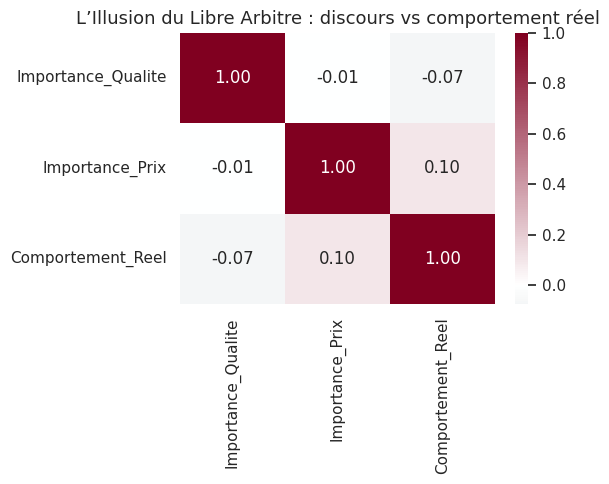

In [ ]:
# ==============================================================================
# VISUALISATION 4 : L'ILLUSION DU LIBRE ARBITRE
# ==============================================================================

df_clean['Comportement_Reel'] = (
    df_clean['Utilise_FastFashion'].astype(str).str.contains('Oui')
).astype(int)

illusion_data = df_clean[[
    'Importance_Qualite',
    'Importance_Prix',
    'Comportement_Reel'
]].dropna()

corr_illusion = illusion_data.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(
    corr_illusion,
    annot=True,
    cmap=custom_cmap,
    center=0,
    fmt=".2f"
)

plt.title("L’Illusion du Libre Arbitre : discours vs comportement réel", fontsize=13)
plt.tight_layout()
plt.show()


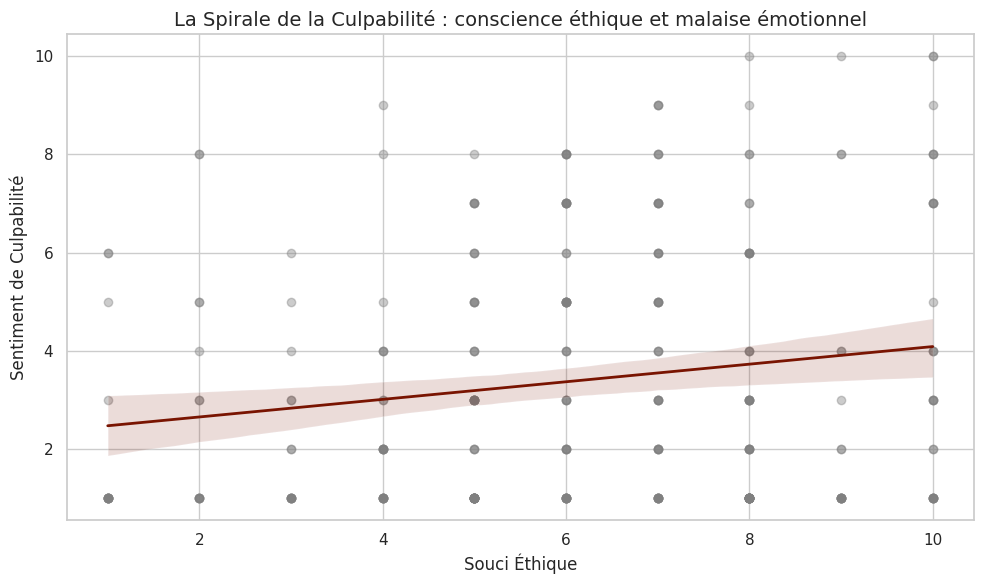

In [ ]:
# ==============================================================================
# VISUALISATION 5 : LA SPIRALE DE LA CULPABILITÉ
# ==============================================================================

plt.figure(figsize=(10, 6))

sns.regplot(
    data=df_clean,
    x='Souci_Ethique',
    y='Sentiment_Culpabilite',
    scatter_kws={'alpha':0.4, 'color':'grey'},
    line_kws={'color':'#791401', 'linewidth':2}
)

plt.title("La Spirale de la Culpabilité : conscience éthique et malaise émotionnel", fontsize=14)
plt.xlabel("Souci Éthique")
plt.ylabel("Sentiment de Culpabilité")
plt.tight_layout()
plt.show()
